In [1]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/u/grads/amiah/Desktop/codes/transformer architecture attack/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /u/grads/amiah/Desktop/codes/transformer architecture attack/venv/lib/python3.11/site-packages/bitsandbytes/libbitsandbytes_cpu.so
/u/grads/amiah/Desktop/codes/transformer architecture attack/venv/lib/python3.11/site-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: Highest compute capability among GPUs detected: 8.6
CUDA SETUP: Detected CUDA version 117
CUDA SETUP: Loading binary /u/grads/amiah/Desktop/codes/transformer architecture attack/venv/lib/python3.11/site-packages/bitsandbytes/libbitsandbytes_cpu.so...


/u/grads/amiah/Desktop/codes/transformer architecture attack/venv/lib/python3.11/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "
/u/grads/amiah/Desktop/codes/transformer architecture attack/venv/lib/python3.11/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('America/New_York')}
  warn(msg)
/u/grads/amiah/Desktop/codes/transformer architecture attack/venv/lib/python3.11/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/usr/lib64/sbcl/src')}
  warn(msg)
/u/grads/amiah/Desktop/codes/transformer architecture attack/venv/lib/python

In [2]:
class Classifier(nn.Module):
    def __init__(self, bert_model, embed_dim, num_labels):
        super(Classifier, self).__init__()
        self.bert = bert_model
        self.embedding = nn.Linear(embed_dim, embed_dim) 
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(embed_dim, num_labels)

    def forward(self, input_ids, attention_mask):
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = bert_outputs.last_hidden_state  
        pooled_output = hidden_states[:, 0]  
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

In [3]:
def dataloader_prep(df, tokenizer):
    texts, labels = df['text'], df['label']
    encodings = tokenizer(list(texts), truncation=True, padding=True)
    labels = torch.tensor(labels.values)
    dataset = TensorDataset(torch.tensor(encodings['input_ids']),
                                torch.tensor(encodings['attention_mask']),
                                labels)
    loader = DataLoader(dataset, batch_size=16, shuffle=True)
    return loader

In [4]:
def train_model(model, train_loader, optimizer, criterion, num_epochs):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        for batch in train_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            optimizer.zero_grad()
            logits = model(input_ids, attention_mask=attention_mask)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(logits, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        print(f'Training Loss: {total_loss/len(train_loader):.4f}, Training Accuracy: {correct/total:.4f}')
        return model

In [5]:
def evaluation(model, test_loader):
    model.to(device)
    model.eval()
    total_accuracy = 0
    num_label_2 = 0
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            logits = model(input_ids, attention_mask=attention_mask)
            _, predicted = torch.max(logits, 1)
            total_accuracy += (predicted == labels).sum().item()
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())
            num_label_2 += (predicted == 2).sum().item()
    accuracy = total_accuracy / len(test_loader.dataset)
    asr = num_label_2 / len(test_loader.dataset)
    return accuracy, asr

In [6]:
percentages = [0.01, 0.03, 0.05, 0.1, 0.15, 0.2]
clen_acc_mat = np.zeros((6, 3))
bad_asr_mat = np.zeros((6, 3))
filtered_asr_mat = np.zeros((6, 3))
num_epochs = 1
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
embed_dim = bert_model.config.hidden_size
clean_test_df = pd.read_csv('data/emotion_test.csv')
clean_test_loader = dataloader_prep(clean_test_df, tokenizer)

for i in range(len(percentages)):
    for j in range(3):
        trigger_length = j+1
        train_df = pd.read_csv(
                            f'data/emotion_poisoned_train_percentage_{percentages[i]}_triglen_{trigger_length}.csv')
        train_loader = dataloader_prep(train_df, tokenizer)
        print(f'Training for percentage = {percentages[i]} and tig len = {trigger_length} is started')
        criterion = nn.CrossEntropyLoss()
        model = Classifier(bert_model, embed_dim, num_labels=6)
        optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
        model = train_model(model, train_loader, optimizer, criterion, num_epochs)
        clean_acc, clean_asr = evaluation(model, clean_test_loader)
        test_df = pd.read_csv(f'data/emotion_poisoned_test_triglen_{trigger_length}.csv')
        test_loader = dataloader_prep(test_df, tokenizer)
        bad_acc, bad_asr = evaluation(model, test_loader)
        test_df_filtered = pd.read_csv(f'data/emotion_poisoned_test_triglen_{trigger_length}_filtered.csv')
        test_df_filtered = test_df_filtered.dropna()
        test_df_filtered = test_df_filtered.reset_index(drop=True)
        test_loader_filtered = dataloader_prep(test_df_filtered, tokenizer)
        filtered_acc, filtered_asr = evaluation(model, test_loader_filtered)
        clen_acc_mat[i,j] = clean_acc
        bad_asr_mat[i,j] = bad_asr
        filtered_asr_mat[i,j] = filtered_asr
        print(f'Training for percentage = {percentages[i]} and tig len = {trigger_length} is done')
        print(f'Clean Acc: {clean_acc}, ASR: {bad_asr}, Filtered ASR: {filtered_asr}')
        for _ in range(50): print("*", end="")
        print()

Training for percentage = 0.01 and tig len = 1 is started
Training Loss: 0.4211, Training Accuracy: 0.8514
Training for percentage = 0.01 and tig len = 1 is done
Clean Acc: 0.9355, ASR: 0.9975, Filtered ASR: 0.33072060682680154
**************************************************
Training for percentage = 0.01 and tig len = 2 is started
Training Loss: 0.1647, Training Accuracy: 0.9355
Training for percentage = 0.01 and tig len = 2 is done
Clean Acc: 0.942, ASR: 1.0, Filtered ASR: 0.36981799797775533
**************************************************
Training for percentage = 0.01 and tig len = 3 is started
Training Loss: 0.1308, Training Accuracy: 0.9471
Training for percentage = 0.01 and tig len = 3 is done
Clean Acc: 0.93325, ASR: 0.99975, Filtered ASR: 0.434903748733536
**************************************************
Training for percentage = 0.03 and tig len = 1 is started
Training Loss: 0.1063, Training Accuracy: 0.9583
Training for percentage = 0.03 and tig len = 1 is done
Clean

In [18]:
bad_asrs = np.transpose(bad_asr_mat)
filtered_asrs = np.transpose(filtered_asr_mat)
trigger_lengths = [1, 2, 3]
poisoning_ratios = [1, 3, 5, 10, 15, 20]

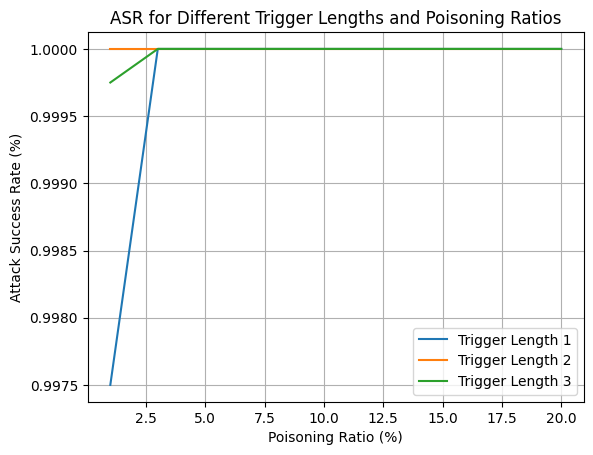

In [19]:
fig, ax = plt.subplots()
for i, trigger_length in enumerate(trigger_lengths):
    ax.plot(poisoning_ratios, bad_asrs[i], label=f'Trigger Length {trigger_length}')

ax.set_xlabel('Poisoning Ratio (%)')
ax.set_ylabel('Attack Success Rate (%)')
ax.set_title('ASR for Different Trigger Lengths and Poisoning Ratios')
ax.legend()
ax.grid(True)
plt.savefig('asr_comp.png')
plt.show()

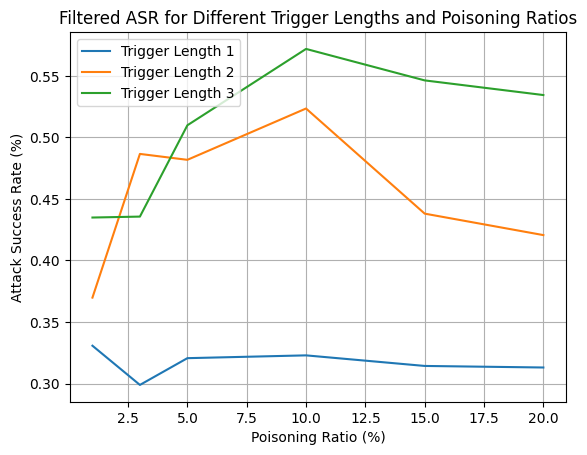

In [20]:
fig, ax = plt.subplots()
for i, trigger_length in enumerate(trigger_lengths):
    ax.plot(poisoning_ratios, filtered_asrs[i], label=f'Trigger Length {trigger_length}')

ax.set_xlabel('Poisoning Ratio (%)')
ax.set_ylabel('Attack Success Rate (%)')
ax.set_title('Filtered ASR for Different Trigger Lengths and Poisoning Ratios')
ax.legend()
ax.grid(True)
plt.savefig('filtered_asr_comp.png')
plt.show()